In [8]:
! pip install --quiet "matplotlib" "numpy <3.0" "pytorch-lightning >=2.0,<2.5" "torchmetrics>=1.0, <1.5" "seaborn" "torch>=1.8.1, <2.5" "pandas" "torchvision"

In [9]:
import os

import pandas as pd
import pytorch_lightning as pl
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.display import display
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel
from torch.utils.data import DataLoader, random_split
from torchmetrics.functional import accuracy
from torchvision.datasets import CIFAR10

pl.seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

In [10]:
cifar10_normalization = torchvision.transforms.Normalize(
    mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
    std=[x / 255.0 for x in [63.0, 62.1, 66.7]],
)


def split_dataset(dataset, val_split=0.2, train=True):
    """Splits the dataset into train and validation set."""
    len_dataset = len(dataset)
    splits = get_splits(len_dataset, val_split)
    dataset_train, dataset_val = random_split(dataset, splits, generator=torch.Generator().manual_seed(42))

    if train:
        return dataset_train
    return dataset_val


def get_splits(len_dataset, val_split):
    """Computes split lengths for train and validation set."""
    if isinstance(val_split, int):
        train_len = len_dataset - val_split
        splits = [train_len, val_split]
    elif isinstance(val_split, float):
        val_len = int(val_split * len_dataset)
        train_len = len_dataset - val_len
        splits = [train_len, val_len]
    else:
        raise ValueError(f"Unsupported type {type(val_split)}")

    return splits


train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization,
    ]
)
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization,
    ]
)

dataset_train = CIFAR10(PATH_DATASETS, train=True, download=True, transform=train_transforms)
dataset_val = CIFAR10(PATH_DATASETS, train=True, download=True, transform=test_transforms)
dataset_train = split_dataset(dataset_train)
dataset_val = split_dataset(dataset_val, train=False)
dataset_test = CIFAR10(PATH_DATASETS, train=False, download=True, transform=test_transforms)

train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [11]:
def create_model():
    model = torchvision.models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model

In [12]:
class LitResnet(pl.LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [13]:
model = LitResnet(lr=0.05)

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    devices=1,
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step")],
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
trainer.test(model, dataloaders=test_dataloader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8105999827384949     │
│         test_loss         │    0.5460470914840698     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5460470914840698, 'test_acc': 0.8105999827384949}]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,lr-SGD,test_acc,test_loss,train_loss,val_acc,val_loss
epoch,,,,,,
NaN,0.012079,NaN,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,1.82604,NaN,NaN
NaN,0.034132,NaN,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,1.66406,NaN,NaN
NaN,0.062440,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


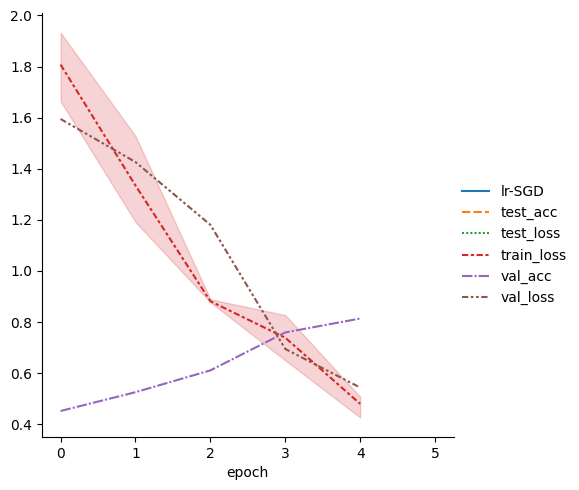

In [14]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [15]:
class SWAResnet(LitResnet):
    def __init__(self, trained_model, lr=0.01):
        super().__init__()

        self.save_hyperparameters("lr")
        self.model = trained_model
        self.swa_model = AveragedModel(self.model)

    def forward(self, x):
        out = self.swa_model(x)
        return F.log_softmax(out, dim=1)

    def on_train_epoch_end(self):
        self.swa_model.update_parameters(self.model)

    def validation_step(self, batch, batch_idx, stage=None):
        x, y = batch
        logits = F.log_softmax(self.model(x), dim=1)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.hparams.lr, momentum=0.9, weight_decay=5e-4)
        return optimizer

    # def on_train_end(self):  # todo: failing as trainer has only dataloaders, not datamodules
    #     update_bn(self.trainer.datamodule.train_dataloader(), self.swa_model, device=self.device)

In [ ]:
swa_model = SWAResnet(model.model, lr=0.01)

swa_trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    devices=1,
    logger=CSVLogger(save_dir="logs/"),
)

swa_trainer.fit(swa_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
swa_trainer.test(swa_model, dataloaders=test_dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'trained_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['trained_model'])`.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")